In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel

In [2]:
ipums_df = pd.read_csv('raw_combined.csv')
print(ipums_df.shape)

/var/folders/r3/r8n4d89j14d85zd6bmhlq8380000gn/T/ipykernel_84910/2183184921.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  ipums_df = pd.read_csv('raw_combined.csv')


(149057, 357)


In [3]:
ipums_df.head()

,Unnamed: 0,PERSONID,REFID,YEAR,WEIGHT,SAMPLE,SURID,COHORT,SRVMODE,SEQNUM,...,NWILL,NWLAY,NWNOND,NWOCNA,NWOT,NWOTP,NWRET,NWSTU,HHLOSE,HHLOSENO
0,397656,50000030000000006,500300006,2010,80.3618,901,1,101,1.0,1,...,NaN,98,98,98,NaN,98,NaN,98,NaN,NaN
1,397657,50000030000000104,500300014,2010,648.6910,901,1,101,4.0,2,...,NaN,0,0,0,NaN,1,NaN,0,NaN,NaN
2,397658,50000030000000108,500300018,2010,684.1937,901,1,101,4.0,3,...,NaN,98,98,98,NaN,98,NaN,98,NaN,NaN
3,397659,50000030000000305,500300035,2010,370.1036,901,1,101,1.0,4,...,NaN,98,98,98,NaN,98,NaN,98,NaN,NaN
4,397660,50000030000000308,500300038,2010,472.9408,901,1,101,4.0,5,...,NaN,98,98,98,NaN,98,NaN,98,NaN,NaN


In [4]:
ipums_df = ipums_df.loc[:, ~ipums_df.columns.str.contains('^Unnamed')]

In [5]:
ipums_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149057 entries, 0 to 149056
Columns: 356 entries, PERSONID to HHLOSENO
dtypes: float64(214), int64(141), object(1)
memory usage: 404.8+ MB


In [6]:
for col in ipums_df.select_dtypes(include=['object', 'category']).columns:
    ipums_df[col] = LabelEncoder().fit_transform(ipums_df[col].astype(str))

In [7]:
X = ipums_df.drop(columns=['SALARY'])
y = ipums_df['SALARY']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [10]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("Top 20 important features:")
print(importances.head(20))

Top 20 important features:
WEIGHT      0.021547
SEQNUM      0.020560
REFID       0.020339
AGE         0.018460
WASEC       0.017272
EMSIZE      0.016344
PERSONID    0.015904
NOCPR       0.014983
NBAMED      0.014377
NOCPRMG     0.013888
WAPRI       0.013261
SATBEN      0.013056
SATSOC      0.012938
SATSAL      0.012871
WASCSM      0.012621
NMRMEDR     0.012400
NDGMED      0.012393
SATCHAL     0.012199
BIRYR       0.012140
BA03Y5      0.011884
dtype: float64


In [13]:
# Technical / ID columns
drop_cols = ['WEIGHT', 'PERSONID', 'SEQNUM', 'REFID']

# Redundant children indicators
drop_cols += ['CHU2IN', 'CH6IN', 'CH25IN', 'CH611IN', 'CHUN12', 'CH1217IN', 'CH1218IN', 'CH18IN', 'CH19IN']

# Overlapping degree year intervals (keep only one per degree type)
drop_cols += ['HDAY5','HD03Y5','MR5YR','MR03Y5','BAAYR5','BA03Y5']

# Drop fine-grained financial support if aggregating
drop_cols += ['HDFGFT','HDFGRN','HDFLN','HDFOT','HDFPLN',
              'MRFGFT','MRFGRN','MRFLN','MRFOT','MRFPLN',
              'BAFGFT','BAFGRN','BAFLN','BAFOT','BAFPLN']

drop_cols += [
    # Current enrollment reasons
    'ACADV','ACCAR','ACCHG','ACINT','ACLIC','ACOTP','ACSKL','TCEM','TCGRD',
    'NCBRK','NCCHG','NCFAM','NCFIN','NCGOAL','NCJOB','NCMOVE','NCTERM','NCOT','NCPRI','NCSEC',
    
    # Financial support for courses (optional if aggregating)
    'ACCCEP','FAAST','FAEM','FAERN',
    
    # Community college reasons (survey responses)
    'CCADVPL','CCASDG','CCBSDG','CCCHGFL','CCCOLPR','CCFIN','CCGED','CCINT','CCOT','CCPRAD','CCSKL'
]

In [14]:
X_rf = ipums_df.drop(columns=['SALARY'], errors='ignore').copy()
y_rf = ipums_df['SALARY'].copy()

In [15]:
for col in X_rf.select_dtypes(include=['object', 'category']).columns:
    X_rf[col] = LabelEncoder().fit_transform(X_rf[col].astype(str))

In [16]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42
)

In [17]:
if y_rf.dtype == 'object' or (str(y_rf.dtype).startswith('int') and len(y_rf.unique()) < 20):
    rf_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
else:
    rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

rf_model.fit(X_train_rf, y_train_rf)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [18]:
importances_rf = pd.Series(rf_model.feature_importances_, index=X_rf.columns).sort_values(ascending=False)
print(importances_rf)

NOCPRMG     0.039997
ACTCAP      0.039996
JOBINS      0.034998
JOBPROFT    0.034997
SATSOC      0.029998
              ...   
OCOMG       0.000000
OCO         0.000000
ICOLLAB     0.000000
HHLOSE      0.000000
HHLOSENO    0.000000
Length: 355, dtype: float64


In [19]:
print(importances_rf.head(50))

NOCPRMG     0.039997
ACTCAP      0.039996
JOBINS      0.034998
JOBPROFT    0.034997
SATSOC      0.029998
WACOM       0.029997
WAOT        0.029997
MGRNAT      0.024999
SATBEN      0.024998
OCEDRLP     0.024998
SATCHAL     0.024998
WADSN       0.024998
WASVC       0.024998
NWNOND      0.024998
SATSAL      0.020010
EMSEC       0.020002
HRSWKGR     0.020001
SUPWK       0.020000
WASEC       0.019999
WAPRSM      0.019998
WASCSM      0.019998
SATRESP     0.019998
WASALE      0.019998
WADEV       0.019998
ACTTCH      0.019998
NWSTU       0.019998
NOCPR       0.015002
EMSIZE      0.015001
MGROTH      0.014999
SATIND      0.014999
JOBSATIS    0.014999
WAMGMT      0.014999
WAEMRL      0.014999
WABRSH      0.014999
ACTMGT      0.014999
ACTDED      0.014999
ACTRDT      0.014999
NWOCNA      0.014999
WRKG        0.014999
NWLAY       0.014999
SATSEC      0.009999
SATLOC      0.009999
WKSWKGR     0.009999
WAQM        0.009999
MGRSOC      0.009999
NEWBUS      0.009999
WAAPRSH     0.009999
ACTRES      0

In [20]:
# Boolean mask of features with non-zero importance
important_mask = rf_model.feature_importances_ > 0

# Number of features with importance > 0
num_important_features = important_mask.sum()
print("Number of important features (importance > 0):", num_important_features)

Number of important features (importance > 0): 180


In [21]:
from sklearn.feature_selection import SelectFromModel

# Select features with importance above the median
selector_rf = SelectFromModel(rf_model, threshold="median", prefit=True)
X_important = selector_rf.transform(X_rf)

print("Number of selected features (above median importance):", X_important.shape[1])

/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Number of selected features (above median importance): 178


In [23]:
# Keep features with importance > 0.005 (0.5%)
threshold = 0.005
important_mask = rf_model.feature_importances_ > threshold
important_features = X_rf.columns[important_mask]

print("Number of important features above threshold:", important_mask.sum())
print("Top features:", list(important_features))

Number of important features above threshold: 52
Top features: ['LFSTAT', 'WRKG', 'HRSWKGR', 'WKSWKGR', 'JOBINS', 'JOBPENS', 'JOBPROFT', 'LOOKWK', 'OCEDRLP', 'NOCPR', 'NOCPRMG', 'EMSEC', 'EMSIZE', 'NEWBUS', 'WAPRI', 'WAPRSM', 'WASEC', 'WASCSM', 'ACTCAP', 'ACTDED', 'ACTMGT', 'ACTRDT', 'ACTRES', 'ACTTCH', 'WADEV', 'WADSN', 'WAEMRL', 'WAMGMT', 'WAOT', 'WAQM', 'WASALE', 'WASVC', 'WAAPRSH', 'WABRSH', 'WACOM', 'SUPWK', 'JOBSATIS', 'SATBEN', 'SATCHAL', 'SATIND', 'SATLOC', 'SATRESP', 'SATSAL', 'SATSEC', 'SATSOC', 'MGRNAT', 'MGROTH', 'MGRSOC', 'NWLAY', 'NWNOND', 'NWOCNA', 'NWSTU']


In [42]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
import pydotplus
from IPython.display import Image

# Ensure SALARY is numeric
ipums_df['SALARY'] = pd.to_numeric(ipums_df['SALARY'], errors='coerce')

# Drop rows with NaN salary
ipums_df = ipums_df.dropna(subset=['SALARY'])

# Create salary brackets
bins = [0, 30000, 50000, 75000, 100000, 200000]
labels = ['<30k','30-50k','50-75k','75-100k','100k+']

y_dt = pd.cut(ipums_df['SALARY'], bins=bins, labels=labels, include_lowest=True)

# Drop any remaining NaNs in y_dt (just to be safe)
y_dt = y_dt.dropna()

# Align X_dt with cleaned y_dt
X_dt = X_rf.loc[y_dt.index].copy()

# Encode categorical features
for col in X_dt.select_dtypes(include=['object', 'category']).columns:
    X_dt[col] = LabelEncoder().fit_transform(X_dt[col].astype(str))

# Train/test split
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(
    X_dt, y_dt, test_size=0.2, random_state=42
)

# Initialize Decision Tree Classifier
tree = DecisionTreeClassifier(random_state=42, criterion='gini')

# GridSearch for max_depth and max_features
tree_params = {
    'max_depth': range(5, 21),  # allow deeper trees
    'max_features': ['sqrt', 'log2', None]
}

tree_grid = GridSearchCV(
    estimator=tree,
    param_grid=tree_params,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

# GridSearch
tree_grid.fit(X_train_dt, y_train_dt)

#  Train final tree with best params
best_tree = DecisionTreeClassifier(
    criterion='gini',
    max_depth=tree_grid.best_params_['max_depth'],
    max_features=tree_grid.best_params_['max_features'],
    random_state=42
)

best_tree.fit(X_train_dt, y_train_dt)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


DecisionTreeClassifier(max_depth=11, random_state=42)

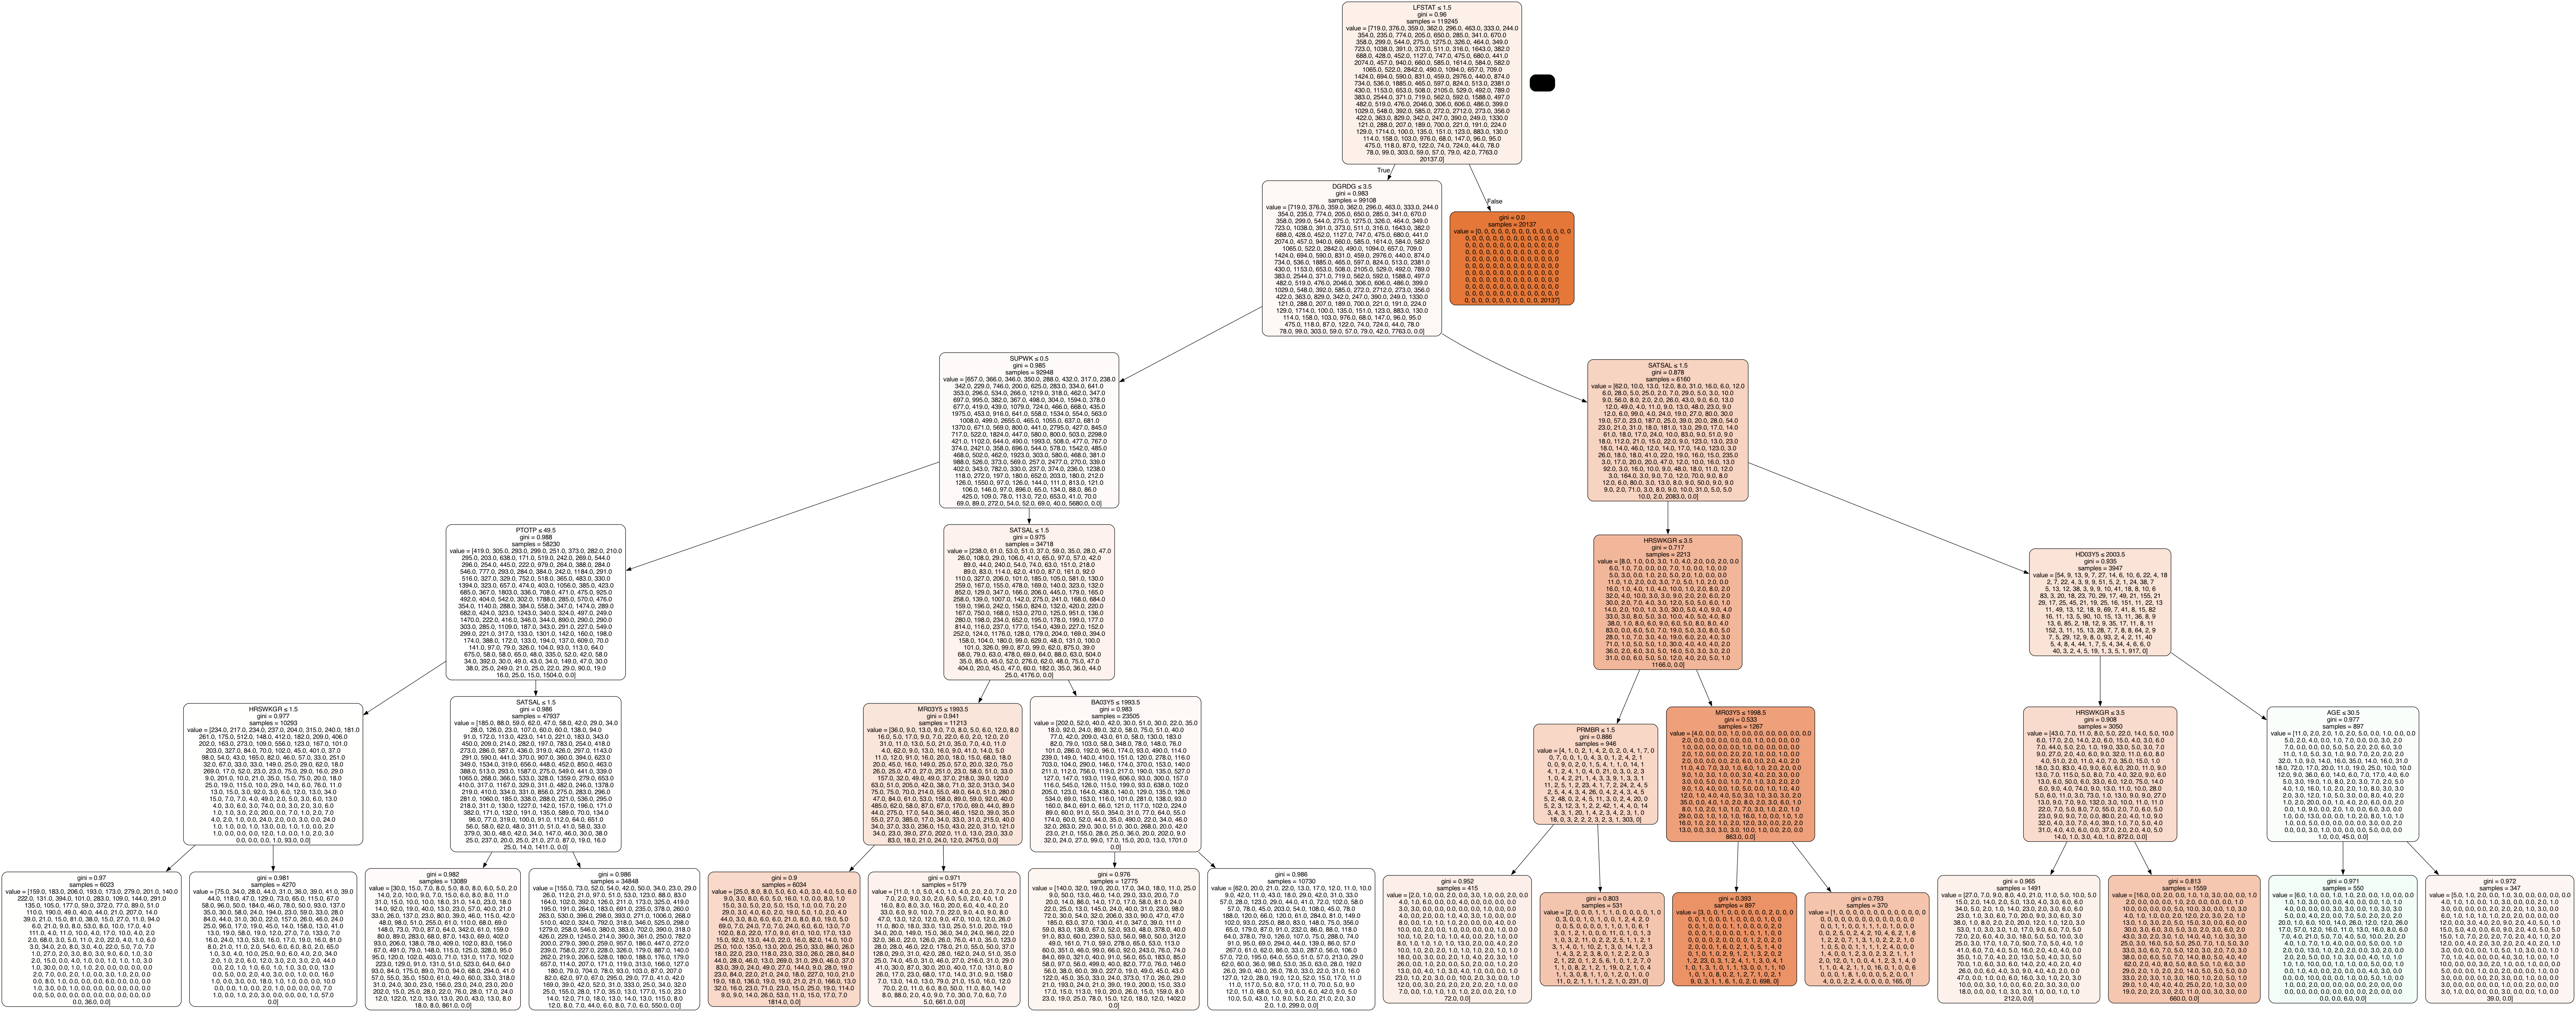

In [39]:
from IPython.display import Image
import matplotlib.pyplot as plt

dot_data = export_graphviz(
    dt_model,
    out_file=None,
    feature_names=X_dt.columns,
    filled=True,
    rounded=True,
    special_characters=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())